In [1]:
import src.acquire
import src.prepare
import src.explore
import src.model

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats

# Addidtional Reporting Outside of Model

1. What state and county are these properties in?
2. Tax Rate for each property
3. Distribution of tax rates for each county
4. How much does the tax rate vary by county?
5. What tax rate do the bulk of the properties sit around?

In [2]:
# load the dataset using the same acquire and prepare files as the model
path='zillow_df.csv'

Df, X_train_explore, \
    X_train_scaled, y_train, \
    X_validate_scaled, y_validate, \
    X_test_scaled, y_test = src.prepare.wrangle_zillow(path)

X_train_scaled.shape, X_validate_scaled.shape, X_test_scaled.shape

((12216, 12), (5236, 12), (4364, 12))

**Use the total datafame**

This infomation has been requested by the customer for the total properties with a transaction from May or June 2017. So instead of use just the train data the full dataset will be used.

Dropped observations
    - 1 dropped because there was no tax amount for this property
    - 14 dropped as outliers because property tax rate was above 10%
    
It 2019 the highest county tax rate in the US was 6.6% so values above 10% in 2017 were determined to be errors and dropped from the dataframe.  
https://www.attomdata.com/news/market-trends/figuresfriday/top-10-u-s-counties-with-the-greatest-effective-tax-rates/

In [3]:
Df.head()

,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fips,fireplace,garage,hottub_spa,latitude,longitude,lotsizesquarefeet,poolcnt,roomcnt,taxvaluedollarcnt,taxamount,zip,useid,year,zip_cc,useid_cc,year_cc
0,3.0,3.0,1534.0,6037.0,0.0,0.0,0.0,33981374.0,-118317057.0,5000.0,0.0,0.0,43439.0,756.94,96028.0,247.0,1940.0,43,1,53
1,2.0,3.0,1458.0,6037.0,0.0,0.0,0.0,34686163.0,-118113100.0,8284.0,1.0,0.0,136104.0,2319.90,97318.0,261.0,1970.0,373,4,83
2,1.0,2.0,1421.0,6037.0,0.0,0.0,0.0,33999877.0,-118291863.0,6707.0,0.0,0.0,35606.0,543.69,96018.0,261.0,1911.0,33,4,24
3,3.0,4.0,2541.0,6059.0,0.0,2.0,0.0,33694636.0,-117912245.0,4975.0,0.0,0.0,880456.0,9819.72,96958.0,261.0,2003.0,286,4,116
4,2.0,3.0,1650.0,6037.0,0.0,0.0,0.0,33985377.0,-118361620.0,7300.0,0.0,0.0,614000.0,7673.19,96037.0,261.0,1949.0,46,4,62


In [4]:
Df.shape

(21816, 20)

# Question 1: What state and county are these properties in?

In [5]:
# how to find state? what is fips column?
# https://en.wikipedia.org/wiki/FIPS_county_code
# https://www.nrcs.usda.gov/wps/portal/nrcs/detail/national/home/?cid=nrcs143_013697

In [6]:
Df.fips.value_counts()

6037.0    14141
6059.0     5878
6111.0     1797
Name: fips, dtype: int64

### per County FIPS Codes list

All properties are located in California, USA   

06037 = Los Angles county

06059 = Orange county

06111 = Ventura county

https://www.nrcs.usda.gov/wps/portal/nrcs/detail/national/home/?cid=nrcs143_013697

In [7]:
# add a column that replaces the fips # with the county name
def get_county(county):
    if county == 6037:
        return 'LA'
    elif county == 6059:
        return 'Orange'
    elif county == 6111:
        return 'Ventura'

Df['county'] = Df.fips.apply(get_county)

In [8]:
Df.head()

,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fips,fireplace,garage,hottub_spa,latitude,longitude,lotsizesquarefeet,...,roomcnt,taxvaluedollarcnt,taxamount,zip,useid,year,zip_cc,useid_cc,year_cc,county
0,3.0,3.0,1534.0,6037.0,0.0,0.0,0.0,33981374.0,-118317057.0,5000.0,...,0.0,43439.0,756.94,96028.0,247.0,1940.0,43,1,53,LA
1,2.0,3.0,1458.0,6037.0,0.0,0.0,0.0,34686163.0,-118113100.0,8284.0,...,0.0,136104.0,2319.90,97318.0,261.0,1970.0,373,4,83,LA
2,1.0,2.0,1421.0,6037.0,0.0,0.0,0.0,33999877.0,-118291863.0,6707.0,...,0.0,35606.0,543.69,96018.0,261.0,1911.0,33,4,24,LA
3,3.0,4.0,2541.0,6059.0,0.0,2.0,0.0,33694636.0,-117912245.0,4975.0,...,0.0,880456.0,9819.72,96958.0,261.0,2003.0,286,4,116,Orange
4,2.0,3.0,1650.0,6037.0,0.0,0.0,0.0,33985377.0,-118361620.0,7300.0,...,0.0,614000.0,7673.19,96037.0,261.0,1949.0,46,4,62,LA


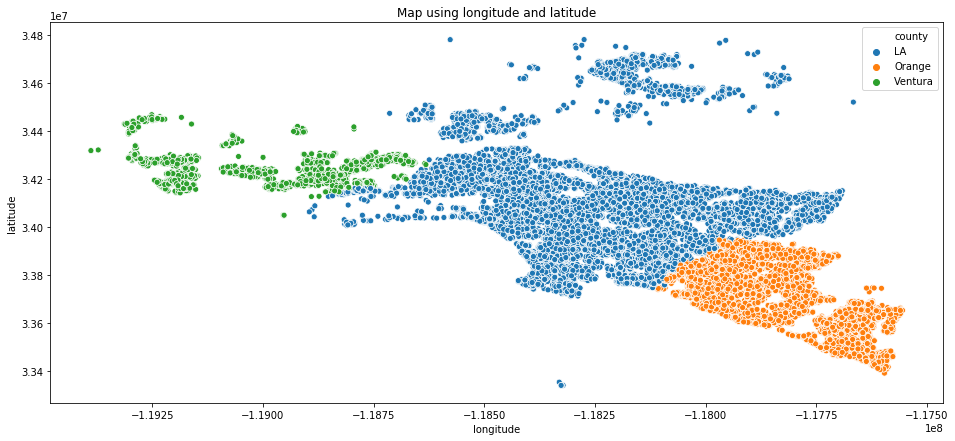

In [9]:
# show where properties are located
plt.figure(figsize=(16, 7))
sns.scatterplot(data=Df, x='longitude', y='latitude', hue='county')
plt.title('Map using longitude and latitude')
plt.show()

# Question 2: Tax Rate for each property?

In [10]:
# add the requested calculation of tax rate
Df['tax_rate'] = Df.taxamount/Df.taxvaluedollarcnt
Df.head()

,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fips,fireplace,garage,hottub_spa,latitude,longitude,lotsizesquarefeet,...,taxvaluedollarcnt,taxamount,zip,useid,year,zip_cc,useid_cc,year_cc,county,tax_rate
0,3.0,3.0,1534.0,6037.0,0.0,0.0,0.0,33981374.0,-118317057.0,5000.0,...,43439.0,756.94,96028.0,247.0,1940.0,43,1,53,LA,0.017425
1,2.0,3.0,1458.0,6037.0,0.0,0.0,0.0,34686163.0,-118113100.0,8284.0,...,136104.0,2319.90,97318.0,261.0,1970.0,373,4,83,LA,0.017045
2,1.0,2.0,1421.0,6037.0,0.0,0.0,0.0,33999877.0,-118291863.0,6707.0,...,35606.0,543.69,96018.0,261.0,1911.0,33,4,24,LA,0.015270
3,3.0,4.0,2541.0,6059.0,0.0,2.0,0.0,33694636.0,-117912245.0,4975.0,...,880456.0,9819.72,96958.0,261.0,2003.0,286,4,116,Orange,0.011153
4,2.0,3.0,1650.0,6037.0,0.0,0.0,0.0,33985377.0,-118361620.0,7300.0,...,614000.0,7673.19,96037.0,261.0,1949.0,46,4,62,LA,0.012497


In [11]:
# quick visualization of the distribution of the overall tax_rate information
Df.tax_rate.describe()

count    21816.000000
mean         0.013110
std          0.003576
min          0.000141
25%          0.011630
50%          0.012265
75%          0.013459
max          0.088893
Name: tax_rate, dtype: float64

In [12]:
Df.tax_rate.median()

0.012264757269605232

### Summary of Overall Tax Rate Information

Min rate = .014%   
Max rate = 8.9%   
mean rate = 1.3%   
median rate = 1.2%   


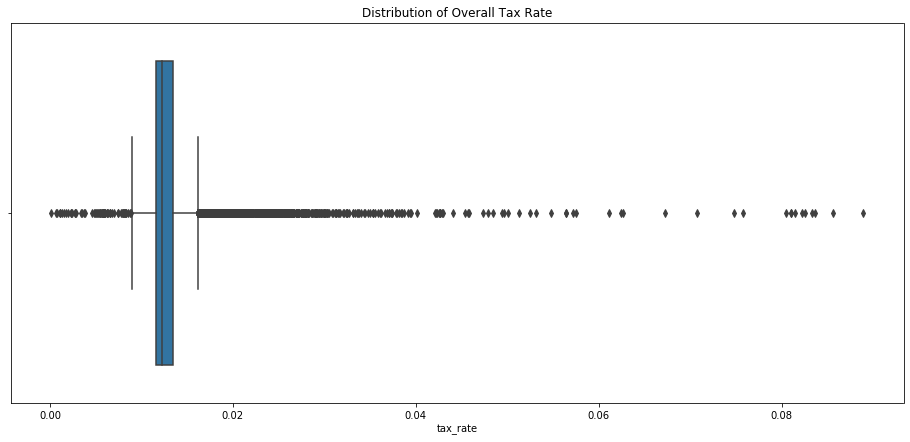

In [13]:
plt.figure(figsize=(16, 7))
sns.boxplot(Df.tax_rate)
plt.title('Distribution of Overall Tax Rate')
plt.show()

# Question 3: Distribution of tax rates for each county?

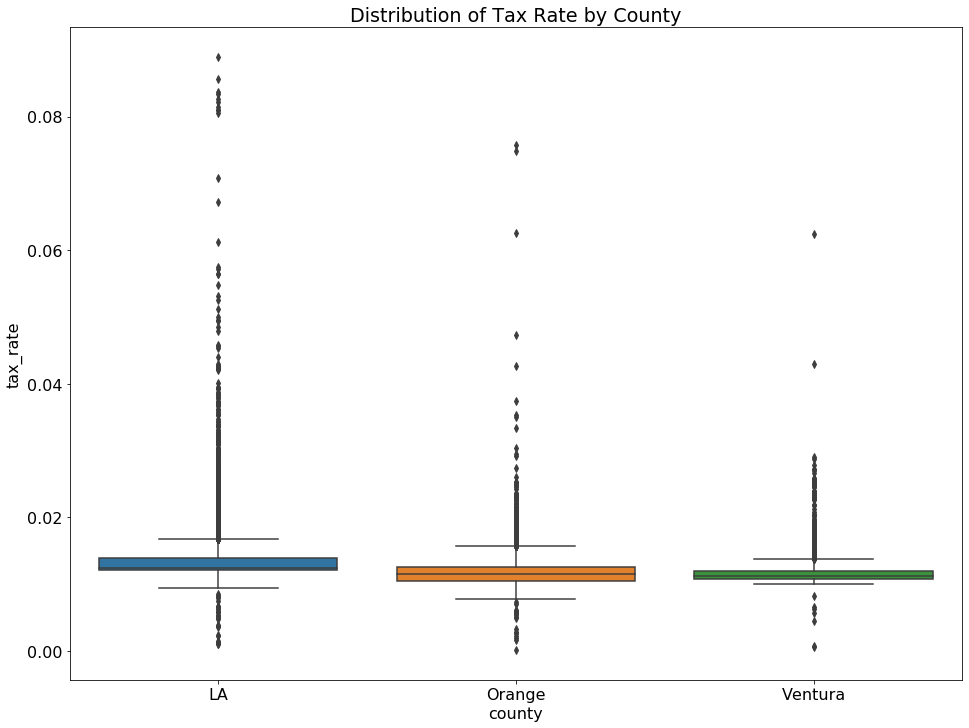

In [14]:
# Show distribution of all 3 counties on 1 chart
plt.figure(figsize=(16, 12))
plt.rcParams.update({'font.size': 16})
sns.boxplot(data=Df, x='county', y='tax_rate')
plt.title('Distribution of Tax Rate by County')
plt.show()

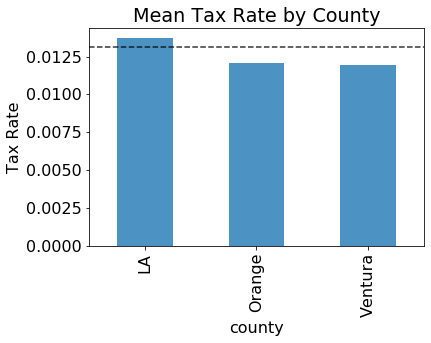

In [15]:
# chart mean tax rate by county with line at overall mean tax rate
total_average = Df.tax_rate.mean()

Df.groupby('county').tax_rate.mean().plot.bar(alpha=.8)
plt.ylabel('Tax Rate')
plt.hlines(total_average, *plt.xlim(), ls='--', alpha=.8)
plt.title('Mean Tax Rate by County')
plt.show()

# Question 4: How much does the tax rate vary by county?

In [16]:
# Variance within each county (question 4)
Df.groupby('county').tax_rate.describe()

,count,mean,std,min,25%,50%,75%,max
county,,,,,,,,
LA,14141.0,0.013700,0.003834,0.001071,0.012086,0.012509,0.013936,0.088893
Orange,5878.0,0.012051,0.002683,0.000141,0.010519,0.011534,0.012590,0.075801
Ventura,1797.0,0.011933,0.002866,0.000677,0.010725,0.011248,0.011931,0.062454


# Question 5: What tax rate do the bulk of the properties sit around?

In [17]:
# use numpy to calculate 1st and 3rd Quartiles, the bulk of the values sit between these 2 points

# First quartile (Q1) 
Q1 = np.percentile(Df.tax_rate, 25, interpolation = 'midpoint') 
  
# Third quartile (Q3) 
Q3 = np.percentile(Df.tax_rate, 75, interpolation = 'midpoint') 

print(f'1st quartile tax rate percentage: {round(Q1, 4)*100}%')
print(f'3rd quartile tax rate percentage: {round(Q3, 4)*100}%')

# The Interquaritle range (IQR) shows the difference between these 2 points
IQR = round((Q3 - Q1), 5) 
  
print(f'The difference of these (IQR) is: {round((round(Q3, 4)*100)-(round(Q1, 4)*100), 4)}%')

1st quartile tax rate percentage: 1.16%
3rd quartile tax rate percentage: 1.35%
The difference of these (IQR) is: 0.19%
